# Round 4. Percolation in Erdös-Rényi (ER) networks

Erdös-Rényi networks are random networks where $N$ nodes are randomly connected such that the probability that a pair of nodes is linked is $p$.
In network science, the ER random graphs are important because they provide the simplest reference to which one can compare real-world networks. Many interesting real networks are very large (in number of nodes) and sparse (in a sense that single nodes have very few connections as compared to the network size). 

We will analyse large and sparse ER graphs, where the average degree $\langle k \rangle$ is some fixed (and small) number, and the size of the network $N$ is very large. Theoretically we will be thinking of networks that are infinitely large, but where $\langle k \rangle$ is still fixed (i.e., $N \to \infty$ and $p \to 0$ such that $p(N-1)=\langle k \rangle$ stays constant). In terms of simulations we will use as large networks as is convenient from the computational point of view, with the idea that larger network sizes will give us better results.

In this exercise, we will analyze the percolation properties of ER graphs. We will especially focus on the \emph{percolation threshold} which is the value of $\langle k \rangle$ where the giant connected component appears (
when $N$ is increasing, based on definition the giant component exists if the size of largest connected component, $S_{\max}$, also grows in proportion to $N$ or in other words $S_{\max}/N \to s_{\max}$ where $s_{\max}>0$).

To get you started, you may use this notebook, although the use of this notebook is fully **optional**. When using this notebook, you only need to fill in the missing parts of some of the functions, but some of the functions do NOT need any modifications. You may start your solution after the subtitle "**Begining of the Exercise**" down below. 

In addition to returning a short report of your results (including the visualizations), return also your commented Python code or notebook. Remember to label the axes in your figures!

In [1]:
import random
import copy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Set the drawing parameters to fit the windows
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

Fontconfig error: Cannot load default config file: No such file: (null)


In [2]:
def calculate_loop_edge_fraction(network, visited_nodes, boundary_nodes):
    """ Calculates the number of edges that go from the boundary to already visited nodes
    in addition to the number of edges that is expected if the network would be a tree.
    This number is then divided by the number of edges in total that go from the boundary
    to the visited nodes.

    In the case that the there are zero edges from the boundary to the visited nodes,
    this function returns zero (i.e., in the beginning when the boundary set is the same
    as the visited nodes).
    
    In the case that in breadth-first search all the reachable nodes have been already discovered, this function returns NaN.

    Parameters
    ----------
    network : networkx.Graph object
    visited_nodes : set object
      The set of nodes that are visited (including the boundary)
    boundary_nodes : set object
      The set of nodes that are in the boundary, i.e., the were visited in the last iteration.

    Returns
    -------
    The fraction described above : float or NaN

    """
    if len(visited_nodes) == 1:
        return 0
    
    if len(boundary_nodes) == 0:
        #all the reachable nodes have been visited before
        return(np.nan)
    
    edge_count = 0

    for node in boundary_nodes:
        for neighbor in network[node]:
            if neighbor in visited_nodes or neighbor in boundary_nodes:
                edge_count += 1

    if edge_count != 0:
        loop_count = edge_count -len(boundary_nodes)
        assert loop_count >= 0
        return loop_count/float(edge_count)
    else:
        return 0

# Beginning of the exercise
Write your code here to analyse large and sparse ER graphs.

### a. Expected number of nodes at $d$ steps away (pen and paper)
It can be shown that large and sparse ER graphs are locally tree-like; meaning that there are few loops of any size and especially very few small loops. For the purposes of this exercises we will assume that the locally tree-like large and sparse ER graphs behave the same as trees. With this assumption, use the idea of branching processes and the concept of excess degree (presented in the lectures) to calculate the expected number of nodes at $d$ steps away, $n_d$, from a randomly selected node in an ER network as a function of $\langle k \rangle$ and $d$. Using this result, justify that in large and sparse ER networks, the giant component appears when $\langle k \rangle > 1$.

**Hints:**
- What is the relationship between $n_d$ and $n_{d-1}$? Can this relationship be re-written as a closed-form expression, that is, a non-recusive relationship that does not involve $n_{d-1}$?
- How does this closed-form expression simplify for the special case of the ER network, given the properties of the degree distribution? Remember that the degree distribution of an ER network is a Poisson distribution when $N \rightarrow \infty$ such that $\langle k \rangle$ is constant. A property of Poisson distribution is that the mean and the variance are equal, in other words, that $\langle k \rangle = \langle k^2 \rangle - {\langle k \rangle}^2$.

### b. Expected number of nodes at $d$ steps away (numerical simulation)
Using numerical simulations calculate the $n_d$ value for $d \in \{0 \dots 15\} $, $\langle k \rangle \in \{ 0.5, 1, 2\} $, and starting from enough randomly selected nodes to get a good estimate for the expected value. Try out two network sizes: $N=10^4$ and $N=10^5$ to see how the size affects the calculations. Present a plot of mean $n_d$ as a function of $d$ for different values of $k$.

For this and the following tasks, you can use the Python template provided alongside the exercise. Note that the code in the template reports the plots for sections b) and c) as one set for easier comparison. A reasonable number for starting nodes can be anywhere from hundreds to thousands based on how fast your computer and your simulation code is. With a moderatly recent computers and an efficient implementation of the algorithm, you should be able to simply use the parameters provided in the the template.

### c. Tree-likeness assumption validity range
In this exercises we will explore the limits to the assumption of local tree-likeness of large, sparse Erdős–Rényi networks. More specifically, we will explore how far from any node you would have to look to see non-tree-like behavior. We will do this by calculating the number of edges that nodes at depth $d$ have that go back to some earlier level in addition to the single edge that connects each node to the level $d-1$, and reporting the average fraction of such edges to all edges that go from depth $d$ to earlier levels/depths. In a perfect tree this fraction is exactly 0. Plot this fraction as a function of $d$.

In [3]:
def create_er_network(net_size, avg_degree):
    """Creates a realisation of an Erdos-Renyi network.

    Parameters
    ----------
    net_size : int
       Number of nodes in the network.
    avg_degree : float
       The value of edge probability p is set such that this is the
       expected average degree in the network.

    Returns
    -------

    net: a network object

    """
    p = avg_degree / net_size
    net = nx.fast_gnp_random_graph(net_size, p)
    # Use the fast function fast_gnp_random_graph to create the ER graph!
    return net
net = create_er_network(100, 4)

In [4]:
def expand_breadth_first_search(network, visited_nodes, boundary_nodes):
    """Performs one step in a breadth first search and updates the visited nodes
    and boundary nodes sets that are given as parameters accordingly. Here one
    step means that we will find all nodes that are one step further away from
    the starting node. These nodes will form the new boundary.

    Parameters
    ----------
    network : networkx.Graph object
    visited_nodes : set object
      The set of nodes that are visited (including the boundary)
    boundary_nodes : set object
      The set of nodes that are in the boundary, i.e., the were visited in the last iteration.

    Returns
    -------
    
    new_visited_nodes : set object
        The new and updated set of visited nodes after exploring one more step
    new_boundary_nodes : set object
        The new set of boundary nodes after exploring for one more step
    """

    new_boundary_nodes = set()
    # Let's make a copy of visited_nodes to avoid accidental mutations of the
    # function arguments:
    new_visited_nodes = set(visited_nodes)

    # Go through all the nodes in the "boundary_nodes", and add all their
    # neighbors that are not already visited to the "new_boundary_nodes".
    # Remember to update the "new_visited_nodes" as you go. Do *not* modify
    # the sets "boundary_nodes" or "visited_nodes".
    # YOUR CODE HERE
    for node in boundary_nodes:
        neighborns = network.neighbors(node)
        for neighborn in neighborns:
            if neighborn not in visited_nodes:
                new_boundary_nodes.add(neighborn)
                new_visited_nodes.add(neighborn)

    return new_visited_nodes, new_boundary_nodes
expand_breadth_first_search(net, set([1, 2, 3]), set([1, 2, 3]))

({1, 2, 3, 11, 24, 28, 47, 60, 93}, {11, 24, 28, 47, 60, 93})

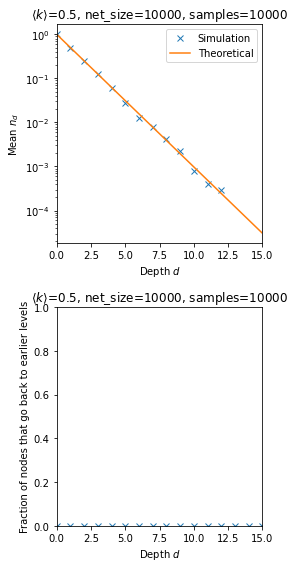

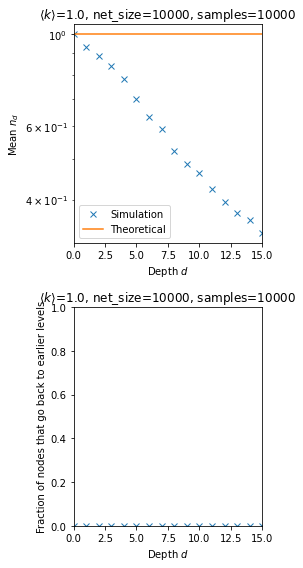

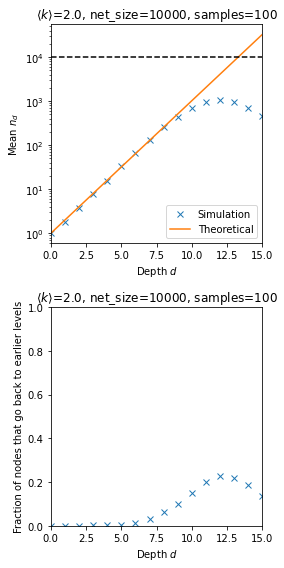

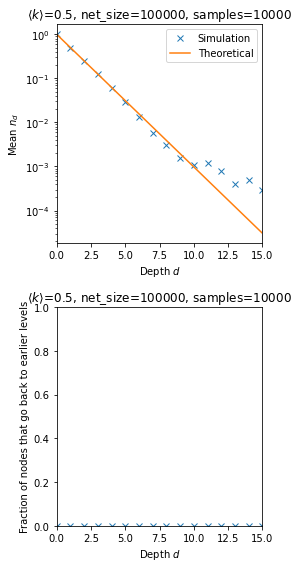

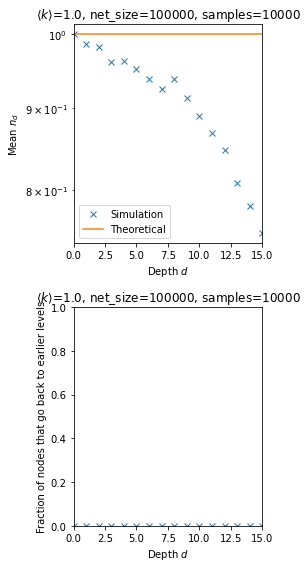

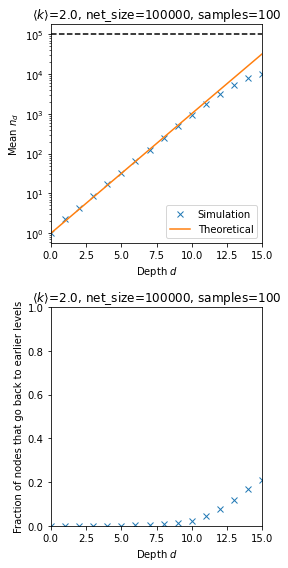

In [18]:
def er_breadth_first_search(avg_degree, net_size, number_of_samples, max_depth):
    """Performs a number of breadth-first searches from random starting points
    on randomly generated ER networks and calculates the average number of nodes
    (i.e. number of boundry nodes) and the fraction of looping edges encounterd
    at each step.

    Parameters
    ----------
    avg_degree : float
      The expected degree of the nodes in the ER network
    net_size : int
      The number of nodes in the ER network
    number_of_samples : int
       The number of randomly selected starting node for the BFS
    max_depth : int
       The maximum depth of the BFS

    Returns
    -------
    avg_node_count : list
        list of max_depth+1 floats, where index d is the expected size of the
        boundry d steps from a randomly selected source.
    loop_edge_fraction: list
        list of max_depth+1 floats, where index d is the expected fraction of
        looping edges d steps from a randomly selected source.

    """
    net = create_er_network(net_size, avg_degree)

    # We will count the number of nodes and the loop fraction for each depth and each
    # starting node. That is, we need a 2-dimensional list to save these results.
    # The element node_count[depth][sample_number] gives the number of nodes at the
    # boundary of the BFS at the given depth for given sample number.
    # The code below will create lists of length max_depth where each element is an empty list.
    node_count = [[] for depth in range(max_depth+1)]
    loop_edge_fraction = [[] for depth in range(max_depth+1)]

    # Next we will run the BFS until max_depth for each randomly selected sample
    for _sample_nr in range(number_of_samples):
        # Choose random starting node:
        start_node = random.randint(0, net_size-1)
        # In the beginning we have only visited the start node:
        visited_nodes = set([start_node])
        # The start node is also the only boundary node, see expand_breadth_first_search:
        boundary_nodes = set([start_node])

        for depth in range(max_depth+1):
            number_of_boundary_nodes = len(boundary_nodes)

            fraction_of_loop_edges = calculate_loop_edge_fraction(
                net, visited_nodes, boundary_nodes)

            # Update the visited nodes and the boundary
            visited_nodes, boundary_nodes = expand_breadth_first_search(
                net, visited_nodes, boundary_nodes)

            # Saving the results
            node_count[depth].append(number_of_boundary_nodes)
            loop_edge_fraction[depth].append(fraction_of_loop_edges)

    # Averaging over the different starting nodes.
    #when calculating average of loop_edge_fraction we use np.nanmean function because we have defined fraction_of_loop_edges to return nan if all the reachable nodes are already visited
    #avg_node_count = list(map(np.mean, node_count))
    avg_node_count = list(map(np.mean, node_count))
    avg_loop_edge_fraction = list(map(np.nanmean, loop_edge_fraction))

    return avg_node_count, avg_loop_edge_fraction

def plot_er_bfs_results(avg_degree, net_size, number_of_samples, max_depth=15,
                        show_netsize=False):
    """Creates plots of mean boundry size and mean loop fraction by performing
    breadth-first searches from random sources in random ER network.
    
    Note that the actual breadth-first searches are performed by calling the
    function `er_breadth_first_search()`. This function is mainly concerened
    with plotting and comparison to the theoritical results.

    Parameters
    ----------
    avg_degree : float
      The expected degree of the nodes in the ER network
    net_size : int
      The number of nodes in the ER network
    number_of_samples : int
       The number of randomly selected starting node for the BFS
    max_depth : int
       The maximum depth of the BFS
    show_netsize : bool
       If True, we will plot the size of the network in the first panel as a dotter horizontal line.

    Returns
    -------
    fig : figure object
    """
    
    avg_node_count, avg_loop_edge_fraction = er_breadth_first_search(
        avg_degree, net_size, number_of_samples, max_depth)

    # Calculating the theoretical values, assuming the network is a tree
    avg_node_count_theoretical = []
    for depth in range(max_depth+1):
        # TODO: check if this is correct
        n = avg_degree**depth # Replace with the formula from part a)

        avg_node_count_theoretical.append(n)
    
    #Plotting the results
    fig = plt.figure(figsize=(4, 8))
        
    ax1 = fig.add_subplot(211)
    ax1.title.set_text(rf"$\langle k \rangle$={avg_degree}, net_size={net_size}, samples={number_of_samples}")

    ax1.semilogy(list(range(max_depth+1)), avg_node_count, "x", label="Simulation")
    ax1.semilogy(list(range(max_depth+1)), avg_node_count_theoretical, label="Theoretical")

    if show_netsize:
        ax1.semilogy([0, max_depth], 2*[net_size], "k--")

    # TODO: check labels
    ax1.set_xlabel("Depth $d$") # Set proper axis labels!
    ax1.set_ylabel("Mean $n_d$") # Set proper axis labels!
    
    ax1.set_xlim(0, max_depth)
    ax1.legend()


    ax2 = fig.add_subplot(212)
    ax2.title.set_text(rf"$\langle k \rangle$={avg_degree}, net_size={net_size}, samples={number_of_samples}")

    
    ax2.plot(list(range(max_depth+1)), avg_loop_edge_fraction, "x", label="Simulation")
    
    # TODO: check it
    ax2.set_xlabel("Depth $d$") # Set proper axis labels!
    ax2.set_ylabel("Fraction of nodes that go back to earlier levels") # Set proper axis labels!
    
    ax2.set_xlim(0, max_depth)
    ax2.set_ylim(0, 1)

    plt.show() # uncomment if you want to display the figure on the screen

    return fig


fig = plot_er_bfs_results(avg_degree=0.5, net_size=10**4, number_of_samples=10000)
fig.savefig('./er_breadthfirst_05_10k.pdf')

fig = plot_er_bfs_results(avg_degree=1.0, net_size=10**4, number_of_samples=10000)
fig.savefig('./er_breadthfirst_1_10k.pdf')

fig = plot_er_bfs_results(avg_degree=2.0, net_size=10**4, number_of_samples=100, show_netsize=True)
fig.savefig('./er_breadthfirst_2_10k.pdf')

fig = plot_er_bfs_results(avg_degree=0.5, net_size=10**5, number_of_samples=10000)
fig.savefig('./er_breadthfirst_05_100k.pdf')

fig = plot_er_bfs_results(avg_degree=1.0, net_size=10**5, number_of_samples=10000)
fig.savefig('./er_breadthfirst_1_100k.pdf')

fig = plot_er_bfs_results(avg_degree=2.0, net_size=10**5, number_of_samples=100, show_netsize=True)
fig.savefig('./er_breadthfirst_2_100k.pdf')

### d. Percolation theshold of ER networks
Calculate the component sizes of simulated ER networks, and use this data to (loosely) verify that the percolation threshold of ER networks is at the average degree of $\langle k \rangle=1$. That is, for $\langle k \rangle < 1$ the largest connected component is small (size being measured as number of nodes), and for $\langle k \rangle > 1$ it quickly reaches the network size.

Do this by generating ER networks of size $N=10^5$ (or $N=10^4$ if you run into memory or processing power problems) with different average degrees: $\langle k \rangle=\left[0.00, 0.05, ..., 2.45, 2.50\right]$. For each of the ER networks, **compute** the size of the **largest** component and **plot** it against $\langle k \rangle$. Note that the code in the template reports the plots for sections d) and e) as one set for easier comparison.

### e. Susceptibility
Another, a more elegant, way to find out when the percolation transition happens is to try to find the point at which the possibility for the largest component size growth is the largest when the control parameter (here $\langle k \rangle$ or $p$) is changed very little. Think about the situation where $\langle k \rangle$ is changed so slightly that a single link is added between the largest component and a randomly selected node that is not in the largest component. The expected change in the largest component size in this situation is some times called \emph{susceptibility}, and it should get very large values at the percolation transition point. The susceptibility depends on the size distribution of all the other components, and it can be calculated with the following formula:

\begin{equation}
\chi = \frac{(\sum_i i^2 C(i)) - S_{max}^2}{(\sum_i i C(i)) - S_{max}} \,,
\end{equation}

where $C(i)$ is the number of components with $i$ nodes. Calculate the susceptibility $\chi$ for each network generated in exercise d), and again plot $\chi$ as a function of $\langle k \rangle$. Explain the shape of the curve, and its implications. 

Calculating components sizes for <k> = 0.0000
Calculating components sizes for <k> = 0.0500
Calculating components sizes for <k> = 0.1000
Calculating components sizes for <k> = 0.1500
Calculating components sizes for <k> = 0.2000
Calculating components sizes for <k> = 0.2500
Calculating components sizes for <k> = 0.3000
Calculating components sizes for <k> = 0.3500
Calculating components sizes for <k> = 0.4000
Calculating components sizes for <k> = 0.4500
Calculating components sizes for <k> = 0.5000
Calculating components sizes for <k> = 0.5500
Calculating components sizes for <k> = 0.6000
Calculating components sizes for <k> = 0.6500
Calculating components sizes for <k> = 0.7000
Calculating components sizes for <k> = 0.7500
Calculating components sizes for <k> = 0.8000
Calculating components sizes for <k> = 0.8500
Calculating components sizes for <k> = 0.9000
Calculating components sizes for <k> = 0.9500
Calculating components sizes for <k> = 1.0000
Calculating components sizes for <

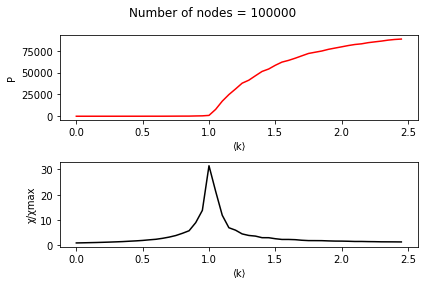

In [20]:
def susceptibility(comp_size_dist):
    """Calculates the susceptibility (as defined in ex. 4.1e)

    Parameters
    ----------
    comp_size_dist : dict
       The component size distribution. See the function `component_size_distribution()`.

    Returns
    -------
    susceptibility : float
    """
    numerator = 0
    denominator = 0
    # Rename because looks better
    dist = comp_size_dist
    for num_nodes in dist:
        num_ccs = dist[num_nodes]
        numerator += (num_nodes**2)*num_ccs
        denominator += (num_nodes)*num_ccs

    S = largest_component_size(dist)
    numerator -= S**2
    denominator -= S
    
    return numerator/denominator



def largest_component_size(comp_size_dist):
    """Finds the largest component in the given component size distribution.

    Parameters
    ----------
    component_size_distribution : dict
       The component size distribution. See the function get_component_size_dist

    Returns
    -------
    largest_comp_size : int
       The number of nodes in the largest connected component
    """
    largest_comp_size = max(comp_size_dist)
    return largest_comp_size


def component_size_distribution(net):
    """Calculates the (unnormalised) component size distribution of a network.

    For example, if the input network has 1 component of size 5 nodes and
    3 components of size 10 nodes, then this function will return a dictionary:
    {5:1, 10:3}.

    Parameters
    ----------
    net : networkx.Graph object

    Returns
    -------
    Dictionary where keys are component sizes and values are the number of
    components of that size.
    """
    dist = {}
    lengths = sorted([len(c) for c in nx.connected_components(net)])
    
    for length in lengths:
        if length in dist:
            dist[length] += 1
        else:
            dist[length] = 1
    return dist

def plot_er_percolation(N, maxk, stepsize=0.1):
    """Builds ER networks with average degrees from 0 to maxk and
       plots the size of the largest connected component and susceptibility
       as a function of the average degree.

    Parameters
    ----------
    N : int
      Number of nodes in the ER network
    maxk : float
      The maximum average degree
    stepsize : float
      The size of the step after which the LCC and susceptibility is calculated.
      I.e., they are plotted at 0, stepsize, 2*stepsize, ..., maxk

    Returns
    -------
    fig : figure handle
    """

    klist = np.arange(0.0, maxk, stepsize)
#     klist = np.arange(1, 1.10, stepsize)
    
    giantsize = []
    smallsize = []

    # Loop over the avg degree range
    for k in klist:
        print("Calculating components sizes for <k> = %.4f" % k)

        # Generate an ER network with N nodes and avg degree k
        net = create_er_network(N, k)

        # Get the distribution of component sizes
        comp_size_dist = component_size_distribution(net)

        # Galculate the largest component size
        giantsize.append(largest_component_size(comp_size_dist))

        # Calculate the avg component size for the other components
        smallsize.append(susceptibility(comp_size_dist))

    # plot the numbers
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)

    ax.plot(klist, giantsize, 'r-')
    ax.set_xlabel('⟨k⟩') # TODO: label the axis!
    ax.set_ylabel('Size of the largest component') # TODO: label the axis!

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(klist, smallsize, 'k-')
    ax2.set_ylabel('χ')  # TODO: label the axis!
    ax2.set_xlabel('⟨k⟩')  # TODO: label the axis!
    
    fig.suptitle('Number of nodes = ' + str(N))
    plt.show() # uncomment if you want to display the figure on the screen

    return fig

fig = plot_er_percolation(10**5, 2.5, 0.05)
fig.savefig('./er_percolation.pdf')